In [1]:
"""
runtime: variable that will help during saving of models and predictions.
This is so that I would not overwrite saved models and predictions with every new run

Each run saves 3 files:
- lgb_models_v{runtime}.pkl
- lgb_output_train_{runtime}.csv
- lgb_output_test_{runtime}.csv
"""
runtime = 16

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import lightgbm as lgb
from lofo import LOFOImportance, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc
import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
to_parse = ['Placement - Time', 'Confirmation - Time', 'Pickup - Time']

df_train = pd.read_csv('../data/df_train.csv', parse_dates=to_parse)
df_test = pd.read_csv('../data/df_test.csv', parse_dates=to_parse)

# initialize test set columns that are in train set but not test set
df_test['Time from Pickup to Arrival'] = np.zeros(df_test.shape[0])
df_test['Arrival at Destination - Day of Month'] = np.zeros(df_test.shape[0])
df_test['Arrival at Destination - Time'] = np.zeros(df_test.shape[0])
df_test['Arrival at Destination - Weekday (Mo = 1)'] = np.zeros(df_test.shape[0])

Feature Engineering

In [4]:
# first create a feature that is particular to train
df_train['Speed'] = df_train['Distance (KM)'] / df_train['Time from Pickup to Arrival']
df_test['Speed'] = np.zeros(df_test.shape[0])

map_P_or_B = {'Personal': 0, 'Business': 1}
def map_personal_or_business(df):
    df['Personal or Business'] = df['Personal or Business'].map(map_P_or_B)
    return df

def convert_to_24hr(df):
    df['Placement - Time'] = df['Placement - Time'].apply(lambda x: x.strftime('%H:%M:%S'))
    df['Confirmation - Time'] = df['Confirmation - Time'].apply(lambda x: x.strftime('%H:%M:%S'))
    df['Pickup - Time'] = df['Pickup - Time'].apply(lambda x: x.strftime('%H:%M:%S'))
    return df

def split_time(df):
    df['placement_hour'] = df['Placement - Time'].dt.hour
    df['confirmation_hour'] = df['Confirmation - Time'].dt.hour
    return df

"""
Missing data in weather columns will be filled by world average
"""
def fill_weather_nan(df):
    df['Temperature'] = df['Temperature'].fillna(22.4)
    return df

"""
Calculate the displacement from the pick up to the destination
"""
def calc_displacement_fromLatLonInKm(df):
    lat1 = df['Pickup Lat']
    lon1 = df['Pickup Long']
    lat2 = df['Destination Lat']
    lon2 = df['Destination Long']
    R = 6371 # radius of the earth in km
    dLat = np.radians(lat2-lat1)
    dLon = np.radians(lon2-lon1)
    
    a = (np.sin(dLat/2))** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * (np.sin(dLon/2))**2
    c = 2 * np.arcsin(np.sqrt(a))
    df['Displacement'] = R * c
    return df

def ratings_weight(df):
    df['ratings_weight'] = df['Average_Rating'] * df['No_of_Ratings']
    return df

def add_dist_feats(df):
    df['dist_diff'] = (df['Distance (KM)']**2) - (df['Displacement']**2)
    return df

def add_angle_feats(df):
    df['sin_angle'] = np.sin(df['Displacement'] / df['Distance (KM)'])
    df['cos_angle'] = np.cos(df['Displacement'] / df['Distance (KM)'])
    df['tan_angle'] = np.tan(df['Displacement'] / df['Distance (KM)'])
    return df


rider_group = df_train.groupby('Rider Id')
rider_stat_mean = rider_group['Time from Pickup to Arrival'].mean().astype(np.float16)
rider_stat_median= rider_group['Time from Pickup to Arrival'].median().astype(np.float16)
rider_stat_min = rider_group['Time from Pickup to Arrival'].min().astype(np.float16)
rider_stat_max = rider_group['Time from Pickup to Arrival'].max().astype(np.float16)
rider_stat_std = rider_group['Time from Pickup to Arrival'].std().astype(np.float16)
rider_stat_count = rider_group['Time from Pickup to Arrival'].count().astype(np.float16)

rider_speed_mean = rider_group['Speed'].mean().astype(np.float16)
rider_speed_median= rider_group['Speed'].median().astype(np.float16)
rider_speed_min = rider_group['Speed'].min().astype(np.float16)
rider_speed_max = rider_group['Speed'].max().astype(np.float16)
rider_speed_std = rider_group['Speed'].std().astype(np.float16)
rider_speed_count = rider_group['Speed'].count().astype(np.float16)

def generate_rider_stats(df):
    df['rider_stat_mean'] = df['Rider Id'].map(rider_stat_mean)
    df['rider_stat_median'] = df['Rider Id'].map(rider_stat_median)
    df['rider_stat_min'] = df['Rider Id'].map(rider_stat_min)
    df['rider_stat_max'] = df['Rider Id'].map(rider_stat_max)
    df['rider_stat_std'] = df['Rider Id'].map(rider_stat_std)
    df['rider_stat_count'] = df['Rider Id'].map(rider_stat_count)
    df['rider_speed_mean'] = df['Rider Id'].map(rider_speed_mean)
    df['rider_speed_median'] = df['Rider Id'].map(rider_speed_median)
    df['rider_speed_min'] = df['Rider Id'].map(rider_speed_min)
    df['rider_speed_max'] = df['Rider Id'].map(rider_speed_max)
    df['rider_speed_std'] = df['Rider Id'].map(rider_speed_std)
    df['rider_speed_count'] = df['Rider Id'].map(rider_speed_count)
    return df

def fill_stat_nan(df):
    df['rider_stat_mean'] = df['rider_stat_mean'].fillna(-100)
    df['rider_stat_median'] = df['rider_stat_median'].fillna(-200)
    df['rider_stat_min'] = df['rider_stat_min'].fillna(-300)
    df['rider_stat_max'] = df['rider_stat_max'].fillna(-400)
    df['rider_stat_std'] = df['rider_stat_std'].fillna(-500)
    df['rider_stat_count'] = df['rider_stat_count'].fillna(-600)
    df['rider_speed_mean'] = df['rider_stat_mean'].fillna(-150)
    df['rider_speed_median'] = df['rider_stat_median'].fillna(-250)
    df['rider_speed_min'] = df['rider_stat_min'].fillna(-350)
    df['rider_speed_max'] = df['rider_stat_max'].fillna(-450)
    df['rider_speed_std'] = df['rider_stat_std'].fillna(-550)
    df['rider_speed_count'] = df['rider_stat_count'].fillna(-650)
    return df

In [5]:
"""
Apply these engineering to the train and test sets
"""

df_train = split_time(df_train)
df_train = map_personal_or_business(df_train)
df_train = convert_to_24hr(df_train)
df_train = fill_weather_nan(df_train)
df_train = calc_displacement_fromLatLonInKm(df_train)
df_train = ratings_weight(df_train)
df_train = add_dist_feats(df_train)
df_train = generate_rider_stats(df_train)
df_train = fill_stat_nan(df_train)

df_test = split_time(df_test )
df_test = map_personal_or_business(df_test)
df_test = convert_to_24hr(df_test)
df_test = fill_weather_nan(df_test)
df_test = calc_displacement_fromLatLonInKm(df_test)
df_test = ratings_weight(df_test)
df_test = add_dist_feats(df_test)
df_test = generate_rider_stats(df_test)
df_test = fill_stat_nan(df_test)


Level 2 feature engineering

In [6]:
df_train['velocity'] = df_train['Displacement'] / df_train['Time from Pickup to Arrival']
df_test['velocity'] = np.zeros(df_test.shape[0])
rider_group = df_train.groupby('Rider Id')

rider_velocity_mean = rider_group['velocity'].mean().astype(np.float16)
rider_velocity_median= rider_group['velocity'].median().astype(np.float16)
rider_velocity_min = rider_group['velocity'].min().astype(np.float16)
rider_velocity_max = rider_group['velocity'].max().astype(np.float16)
rider_velocity_std = rider_group['velocity'].std().astype(np.float16)
rider_velocity_count = rider_group['velocity'].count().astype(np.float16)

def generate_rider_stats(df):
    df['rider_velocity_mean'] = df['Rider Id'].map(rider_velocity_mean)
    df['rider_velocity_median'] = df['Rider Id'].map(rider_velocity_median)
    df['rider_velocity_min'] = df['Rider Id'].map(rider_velocity_min)
    df['rider_velocity_max'] = df['Rider Id'].map(rider_velocity_max)
    df['rider_velocity_std'] = df['Rider Id'].map(rider_velocity_std)
    df['rider_velocity_count'] = df['Rider Id'].map(rider_velocity_count)
    return df

def fill_stat_nan(df):
    df['rider_velocity_mean'] = df['rider_velocity_mean'].fillna(-1150)
    df['rider_velocity_median'] = df['rider_velocity_median'].fillna(-1250)
    df['rider_velocity_min'] = df['rider_velocity_min'].fillna(-1350)
    df['rider_velocity_max'] = df['rider_velocity_max'].fillna(-1450)
    df['rider_velocity_std'] = df['rider_velocity_std'].fillna(-1550)
    df['rider_velocity_count'] = df['rider_velocity_count'].fillna(-1650)
    return df

In [7]:
to_drop = [
           'Vehicle Type',
           'User Id',
           'Arrival at Pickup - Day of Month',
           'Arrival at Pickup - Weekday (Mo = 1)',
           'Arrival at Pickup - Time',
           'Precipitation in millimeters',
           'Rider Id',
           'Arrival at Destination - Day of Month',
           'Arrival at Destination - Time',
           'Arrival at Destination - Weekday (Mo = 1)',
           'Placement - Day of Month',
           'Placement - Weekday (Mo = 1)',
           'Placement - Time',
           'Pickup - Time',
           'Confirmation - Day of Month',
           'Confirmation - Weekday (Mo = 1)',
           'Confirmation - Time',
           'Speed',
           'velocity']

In [8]:
df_train = df_train.drop(to_drop, axis='columns')
df_test = df_test.drop(to_drop, axis='columns')

In [9]:
print(f"Train set shape is {df_train.shape}")
print(f"Test set shape is {df_test.shape}")

Train set shape is (21201, 34)
Test set shape is (7068, 34)


In [10]:
# target = "Time from Pickup to Arrival"
# features = [col for col in df_train.columns if col != target]

category_cols = ['Personal or Business', 'Pickup - Day of Month']

In [11]:
# sample_df = df_train.sample(frac=0.1, random_state=0)
# sample_df.sort_values("AvSigVersion", inplace=True)

In [12]:
# cv = KFold(n_splits=4, shuffle=False, random_state=0)

# # define the validation scheme and scorer. The default model is LightGBM
# lofo_imp = LOFOImportance(sample_df, features, target, cv=cv)

# # get the mean and standard deviation of the importances in pandas format
# importance_df = lofo_imp.get_importance()

# # plot the means and standard deviations of the importances
# plot_importance(importance_df, figsize=(12, 20))

### Training the model

Predictions will be made based on platform type. This is done because the distribution of the predictions are different when it comes to platfrom type 4. The trainings will output a pickle file that contains 4 models. These models contribute a their fair quarter to making predictions on the test

In [13]:
def fetch_train_data_batch(data, platform_type):
    to_train = data.loc[data['Platform Type'] == platform_type]
    to_train_target = to_train['Time from Pickup to Arrival'].values
    to_train_data = to_train.drop(['Order No', 'Time from Pickup to Arrival', 'Unnamed: 0', 'Platform Type'], axis='columns')
    del to_train
    gc.collect()
    return to_train_data, to_train_target

def fetch_test_data_batch(test_data, platform_type):
    to_test_data = test_data.loc[test_data['Platform Type'] == platform_type]
    return to_test_data

In [14]:
def fit_lgbm(train, val, devices=(-1), seed=None, cat_features=None, num_rounds=1500, lr=0.05, bf=0.1):
    """Function to train the Light GBM model"""
    X_tt, y_tt = train
    X_vl, y_vl = val
    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'learning_rate':lr,
        'num_leaves': 2**8,
        'max_depth':20,
        'n_estimators':5000,
        'max_bin':255,
        'num_leaves': 20,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'verbose':-1,
        'seed': 42,
        "bagging_freq": 5,
        "bagging_fraction": bf,
        "feature_fraction": 0.9,
        "metric": 'rmse',
        'early_stopping_rounds':100
    }
    device = devices
    if device == -1:
        pass # use cpu
    else:
        print(f"using gpu {device}...") # use gpu
        params.update({'device': 'gpu', 'gpu_device_id': device})
    params["seed"] = seed
    d_train = lgb.Dataset(X_tt, label=y_tt, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_vl, label=y_vl, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    print("training LGB: ")
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=100)
    print("best score", model.best_score)
    return model

In [15]:
"""
Training will be done per platform type
"""
platform_type = 1
models1 = []

X_train, y_train = fetch_train_data_batch(df_train, platform_type)
gc.collect()
print(f"Training for platform type : {platform_type} on dataset with {X_train.shape[1]} features")

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
kfcv = KFold(n_splits=4)

for train_idx, val_idx in kfcv.split(X_train):
    train_data = X_train.iloc[train_idx], y_train[train_idx]
    val_data = X_train.iloc[val_idx], y_train[val_idx]
    print("Training: ", len(train_idx), " and validating: ", len(val_idx))
    model = fit_lgbm(train_data,val_data,cat_features=category_cols,num_rounds=1000,lr=0.05,bf=0.7)
    models1.append(model)
    gc.collect()
print("training has ended")
gc.collect()

Training for platform type : 1 on dataset with 30 features
Training:  1610  and validating:  537
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 442.245	valid_1's rmse: 686.077
Early stopping, best iteration is:
[53]	training's rmse: 533.22	valid_1's rmse: 679.424
best score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 533.2195424779133)]), 'valid_1': OrderedDict([('rmse', 679.4237919995641)])})
Training:  1610  and validating:  537
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 450.851	valid_1's rmse: 655.153
Early stopping, best iteration is:
[50]	training's rmse: 544.8	valid_1's rmse: 647.945
best score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 544.7998250005708)]), 'valid_1': OrderedDict([('rmse', 647.9447815831523)])})
Training:  1610  and validating:  537
training LGB: 
Training until validation score

0

In [16]:
"""
Training will be done per platform type
"""
platform_type = 2
models2 = []

X_train, y_train = fetch_train_data_batch(df_train, platform_type)
# y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print(f"Training for platform type : {platform_type} on dataset with {X_train.shape[1]} features")

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
kfcv = KFold(n_splits=4)

for train_idx, val_idx in kfcv.split(X_train):
    train_data = X_train.iloc[train_idx], y_train[train_idx]
    val_data = X_train.iloc[val_idx], y_train[val_idx]
    print("Training: ", len(train_idx), " and validating: ", len(val_idx))
    model = fit_lgbm(train_data,val_data,cat_features=category_cols,num_rounds=1000,lr=0.05,bf=0.7)
    models2.append(model)
    gc.collect()
print("training has ended")
gc.collect()

Training for platform type : 2 on dataset with 30 features
Training:  735  and validating:  245
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 430.632	valid_1's rmse: 695.297
Early stopping, best iteration is:
[50]	training's rmse: 541.779	valid_1's rmse: 685.694
best score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 541.7788492096244)]), 'valid_1': OrderedDict([('rmse', 685.6944949840885)])})
Training:  735  and validating:  245
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 449.623	valid_1's rmse: 654.814
Early stopping, best iteration is:
[73]	training's rmse: 503.824	valid_1's rmse: 639.031
best score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 503.8244941108241)]), 'valid_1': OrderedDict([('rmse', 639.0306777644778)])})
Training:  735  and validating:  245
training LGB: 
Training until validation score

0

In [17]:
"""
Training will be done per platform type
"""
platform_type = 3
models3 = []

X_train, y_train = fetch_train_data_batch(df_train, platform_type)
# y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print(f"Training for platform type : {platform_type} on dataset with {X_train.shape[1]} features")

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
kfcv = KFold(n_splits=4)

for train_idx, val_idx in kfcv.split(X_train):
    train_data = X_train.iloc[train_idx], y_train[train_idx]
    val_data = X_train.iloc[val_idx], y_train[val_idx]
    print("Training: ", len(train_idx), " and validating: ", len(val_idx))
    model = fit_lgbm(train_data,val_data,cat_features=category_cols,num_rounds=1000,lr=0.05,bf=0.7)
    models3.append(model)
    gc.collect()
print("training has ended")
gc.collect()

Training for platform type : 3 on dataset with 30 features
Training:  13540  and validating:  4514
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 693.481	valid_1's rmse: 735.449
[200]	training's rmse: 644.666	valid_1's rmse: 730.377
[300]	training's rmse: 607.522	valid_1's rmse: 730.594
[400]	training's rmse: 576.788	valid_1's rmse: 731.147
Early stopping, best iteration is:
[338]	training's rmse: 595.724	valid_1's rmse: 729.616
best score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 595.7241331292045)]), 'valid_1': OrderedDict([('rmse', 729.6159227305819)])})
Training:  13540  and validating:  4514
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 688.157	valid_1's rmse: 757.704
[200]	training's rmse: 641.048	valid_1's rmse: 755.612
Early stopping, best iteration is:
[175]	training's rmse: 651.488	valid_1's rmse: 754.658
best score defaultdict(<cl

0

In [18]:
"""
Training will be done per platform type
"""
platform_type = 4
models4 = []

X_train, y_train = fetch_train_data_batch(df_train, platform_type)
# y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print(f"Training for platform type : {platform_type} on dataset with {X_train.shape[1]} features")

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
kfcv = KFold(n_splits=4)

for train_idx, val_idx in kfcv.split(X_train):
    train_data = X_train.iloc[train_idx], y_train[train_idx]
    val_data = X_train.iloc[val_idx], y_train[val_idx]
    print("Training: ", len(train_idx), " and validating: ", len(val_idx))
    model = fit_lgbm(train_data,val_data,cat_features=category_cols,num_rounds=1000,lr=0.05,bf=1)
    models4.append(model)
    gc.collect()
print("training has ended")
gc.collect()

Training for platform type : 4 on dataset with 30 features
Training:  15  and validating:  5
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1938.37	valid_1's rmse: 2298.98
Early stopping, best iteration is:
[1]	training's rmse: 1938.37	valid_1's rmse: 2298.98
best score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 1938.374525214361)]), 'valid_1': OrderedDict([('rmse', 2298.982230852987)])})
Training:  15  and validating:  5
training LGB: 
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2043.84	valid_1's rmse: 2365.46
Early stopping, best iteration is:
[1]	training's rmse: 2043.84	valid_1's rmse: 2365.46
best score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 2043.8388227385576)]), 'valid_1': OrderedDict([('rmse', 2365.464334966816)])})
Training:  15  and validating:  5
training LGB: 
Training until validation scores don't im

0

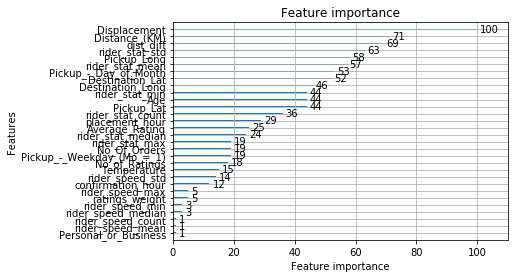

In [19]:
lgb.plot_importance(models1[1])

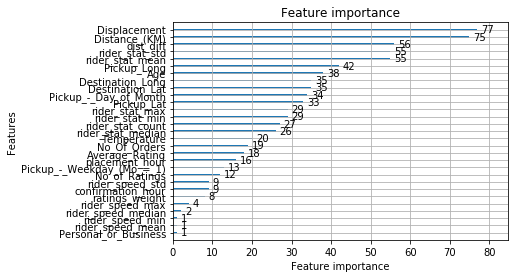

In [20]:
lgb.plot_importance(models1[2])

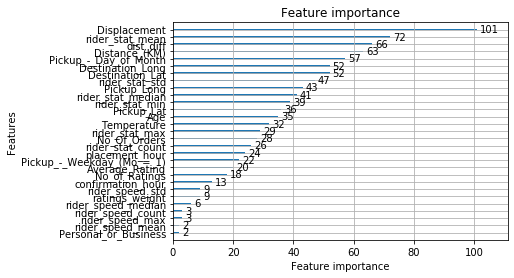

In [21]:
lgb.plot_importance(models1[3])

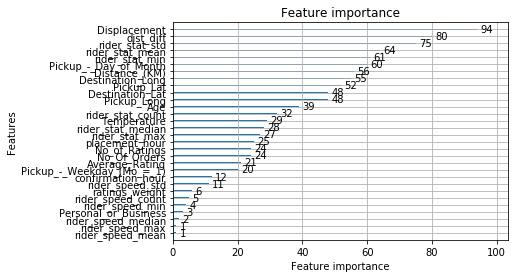

In [22]:
lgb.plot_importance(models1[0])

In [23]:
lgb_models_v = [models1, models2, models3, models4]
# pickle.dump(lgb_models_v, open(f'../output/models/lgb_models_v{runtime}.pkl', 'wb'))

### Make Predictions For VALIDATION SET

Save the index, order no and platform type in order to preserve the order but exclude it from the training features.
The result outputs a file in the output/predictions folder. The file contains the index (yep, I love preserving order), the order no, platform type and predictions

In [24]:
def make_predictions(X_pred, models):
    X_pred_idx = X_pred['Unnamed: 0'] # returning the row_id in order to preserve order
    X_pred_order_no = X_pred['Order No']
    X_pred_platform_type = X_pred['Platform Type']
    X_pred = X_pred.drop(['Order No','Unnamed: 0','Platform Type','Time from Pickup to Arrival'], axis='columns')
    preds_arr = []
    final_predictions_total = np.zeros(X_pred.shape[0])
    for i in range(len(models)):
        print(f"Making predictions for model {i} on dataset with {X_pred.shape[1]} features")
        estimator = models[i]
        predictions = estimator.predict(X_pred, num_iteration=estimator.best_iteration)
        final_predictions_total += predictions
    # Now we are done with the predictions, we'll take the average of the predictions
    final_predictions_total /= len(models)
    final_predictions_total = final_predictions_total
    return X_pred_idx, X_pred_order_no, X_pred_platform_type, final_predictions_total

In [25]:
all_row_ids = []
all_row_order_no = []
all_predictions = []
all_platforms = []

gc.collect()

75

In [26]:
for i in [1, 2, 3, 4]:
    platform_type = i
    use_model = lgb_models_v[i - 1]

    X_valid = fetch_test_data_batch(df_train, platform_type)
    print(f"Starting predictions for Platform type {platform_type}")
    y_valid_id, y_valid_order_no, y_platform, y_valid = make_predictions(X_valid, use_model)
    
    print(f"Appending predictions...")
    all_row_ids.append(y_valid_id)
    all_row_order_no.append(y_valid_order_no)
    all_platforms.append(y_platform)
    all_predictions.append(y_valid)
    print(f"Finished predictions for {platform_type}")

Starting predictions for Platform type 1
Making predictions for model 0 on dataset with 30 features
Making predictions for model 1 on dataset with 30 features
Making predictions for model 2 on dataset with 30 features
Making predictions for model 3 on dataset with 30 features
Appending predictions...
Finished predictions for 1
Starting predictions for Platform type 2
Making predictions for model 0 on dataset with 30 features
Making predictions for model 1 on dataset with 30 features
Making predictions for model 2 on dataset with 30 features
Making predictions for model 3 on dataset with 30 features
Appending predictions...
Finished predictions for 2
Starting predictions for Platform type 3
Making predictions for model 0 on dataset with 30 features
Making predictions for model 1 on dataset with 30 features
Making predictions for model 2 on dataset with 30 features
Making predictions for model 3 on dataset with 30 features
Appending predictions...
Finished predictions for 3
Starting pred

In [27]:
all_row_ids_flat = [ids for sublist in all_row_ids for ids in sublist]
all_row_order_no_flat = [orderno for ordersublist in all_row_order_no for orderno in ordersublist]
all_platforms_flat = [platformtype for platformsublist in all_platforms for platformtype in platformsublist]
all_predictions_flat = [preds for predsublist in all_predictions for preds in predsublist]

In [28]:
model_preds = pd.DataFrame({})
model_preds['Index col'] = all_row_ids_flat
model_preds['Order No'] = all_row_order_no_flat
model_preds['Platform Type'] = all_platforms_flat
model_preds['Time from Pickup to Arrival'] = all_predictions_flat

model_preds = model_preds.sort_values(by=['Index col'])

In [29]:
model_preds.head(10)

,Index col,Order No,Platform Type,Time from Pickup to Arrival
3127,0,Order_No_4211,3,753.495279
3128,1,Order_No_27440,3,2512.478321
3129,2,Order_No_14170,3,1454.861849
3130,3,Order_No_21727,3,2261.259943
2147,4,Order_No_8301,2,1579.827864
3131,5,Order_No_10440,3,2848.782363
0,6,Order_No_25321,1,1331.050951
1,7,Order_No_2476,1,1448.827820
2,8,Order_No_14704,1,1808.498113
3132,9,Order_No_118,3,1948.241624


In [30]:
filename = f"lgb_output_train_{runtime}.csv"
# model_preds.to_csv(f"../output/predictions/{filename}", index=False)
gc.collect()

20

In [31]:
from sklearn.metrics import mean_squared_error as mse

err_ = mse(df_train['Time from Pickup to Arrival'], model_preds['Time from Pickup to Arrival'])
print(f"Model produces a rmse of {np.sqrt(err_)}")

# error = 650.6620174
# error = 690.6855076120686
# with angle = 637.006149, it performs better without the precipitation of 643.0018837
# with speed and velocity added: 647.161

Model produces a rmse of 647.1612620269318


### Make Predictions For TEST SET

In [32]:
all_row_ids = []
all_row_order_no = []
all_predictions = []
all_platforms = []

gc.collect()

40

In [33]:
for i in [1, 2, 3, 4]:
    platform_type = i
    use_model = lgb_models_v[i - 1] # use the appropriate model for each platform type

    X_test = fetch_test_data_batch(df_test, platform_type)
    print(f"Starting predictions for Platform type {platform_type}")
    y_test_id, y_test_order_no, y_platform, y_test = make_predictions(X_test, use_model)
    
    print(f"Appending predictions...")
    all_row_ids.append(y_test_id)
    all_row_order_no.append(y_test_order_no)
    all_platforms.append(y_platform)
    all_predictions.append(y_test)
    print(f"Finished predictions for {platform_type}")

Starting predictions for Platform type 1
Making predictions for model 0 on dataset with 30 features
Making predictions for model 1 on dataset with 30 features
Making predictions for model 2 on dataset with 30 features
Making predictions for model 3 on dataset with 30 features
Appending predictions...
Finished predictions for 1
Starting predictions for Platform type 2
Making predictions for model 0 on dataset with 30 features
Making predictions for model 1 on dataset with 30 features
Making predictions for model 2 on dataset with 30 features
Making predictions for model 3 on dataset with 30 features
Appending predictions...
Finished predictions for 2
Starting predictions for Platform type 3
Making predictions for model 0 on dataset with 30 features
Making predictions for model 1 on dataset with 30 features
Making predictions for model 2 on dataset with 30 features
Making predictions for model 3 on dataset with 30 features
Appending predictions...
Finished predictions for 3
Starting pred

In [34]:
all_row_ids_flat = [ids for sublist in all_row_ids for ids in sublist]
all_row_order_no_flat = [orderno for ordersublist in all_row_order_no for orderno in ordersublist]
all_platforms_flat = [platformtype for platformsublist in all_platforms for platformtype in platformsublist]
all_predictions_flat = [preds for predsublist in all_predictions for preds in predsublist]

In [35]:
model_preds = pd.DataFrame({})
model_preds['Index col'] = all_row_ids_flat
model_preds['Order No'] = all_row_order_no_flat
model_preds['Platform Type'] = all_platforms_flat
model_preds['Time from Pickup to Arrival'] = all_predictions_flat

model_preds = model_preds.sort_values(by=['Index col'])

In [36]:
model_preds.head(10)

,Index col,Order No,Platform Type,Time from Pickup to Arrival
1047,0,Order_No_19248,3,1732.049436
0,1,Order_No_2699,1,2673.987098
1048,2,Order_No_21486,3,1880.931101
1049,3,Order_No_19336,3,2125.708745
1050,4,Order_No_20374,3,2467.197029
1051,5,Order_No_9830,3,1427.315558
1,6,Order_No_17505,1,1682.273039
711,7,Order_No_23802,2,2455.780272
1052,8,Order_No_12736,3,1658.941971
1053,9,Order_No_6400,3,2186.256437


In [37]:
filename = f"lgb_output_test_{runtime}.csv"
# model_preds.to_csv(f"../output/predictions/{filename}", index=False)
print(f"file saved in output > predictions > *** as {filename}")
gc.collect()

file saved in output > predictions > *** as lgb_output_test_16.csv


236